epoch: 0, loss: 0.4267746638123057
epoch: 500, loss: 0.00953307595602898
epoch: 1000, loss: 0.001293765092624799
epoch: 1500, loss: 0.00044036633262115044
epoch: 2000, loss: 0.0008907176115430238
tensor([0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j,
        0.3536+0.j], dtype=torch.complex128, grad_fn=<SqueezeBackward4>)


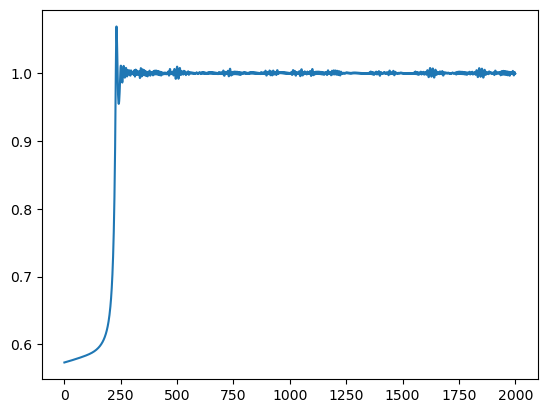

In [3]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

num_qubits = 8

batch_size = 8

num_epochs = 2001

learning_rate = 1e-3

n = 3
N = 2**n

loss_graph = []

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(-2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        dataset = []
        labels = []

        for i in range(num_qubits):
            phi = np.random.rand() * 2*np.pi
            theta = np.random.rand() * np.pi

            input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
            dataset.append(input_qubit)

            q = input_qubit
            q0 = torch.tensor([1,0], dtype=torch.complex128)

            for i in range(n-1):
                q = torch.kron(q,q0)
            q = q @ F
            labels.append(q)
            
        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

class HModel(torch.nn.Module):
    
    def __init__(self):
        super(HModel, self).__init__()
        self.w = Parameter(torch.rand(1, dtype=torch.complex128))
      
    def forward(self, x):
        w = self.w
        
        F = torch.zeros((N,N), dtype=torch.complex128)
        
        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)
            
        q=x
        
        for i in range(n-1):
            q0 = torch.tensor([1,0], dtype=torch.complex128)
            q = torch.kron(q,q0)
            
        return q @ F
    
model = HModel()

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')
        
model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

print(q_out)

x_graph = np.arange(num_epochs * num_qubits / batch_size)
plt.plot(x_graph,loss_graph)

In [48]:
q0 = torch.tensor([1,0])
q1 = torch.tensor([0,1])
h = torch.tensor([[1,1],
                  [1,-1]])
i = torch.tensor([[1,0],
                  [0,1]])
x = torch.tensor([[0,1],
                  [1,0]])
cnot = torch.tensor([[1,0,0,0],
                     [0,1,0,0],
                     [0,0,0,1],
                     [0,0,1,0]])

a = h @ q0
a = torch.kron(a,i)
a = torch.kron(a,i)
b = h @ q1
b = torch.kron(b,i)
b = torch.kron(b,x)
c = a + b
print(a)
print(b)
print(c)

tensor([[1, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1]])
tensor([[ 0,  1,  0,  0,  0, -1,  0,  0],
        [ 1,  0,  0,  0, -1,  0,  0,  0],
        [ 0,  0,  0,  1,  0,  0,  0, -1],
        [ 0,  0,  1,  0,  0,  0, -1,  0]])
tensor([[ 1,  1,  0,  0,  1, -1,  0,  0],
        [ 1,  1,  0,  0, -1,  1,  0,  0],
        [ 0,  0,  1,  1,  0,  0,  1, -1],
        [ 0,  0,  1,  1,  0,  0, -1,  1]])


In [33]:
a = torch.kron(q0,q0)
a = torch.kron(a,q0)
h1 = torch.kron(h,i)
h1 = torch.kron(h1,i)

In [43]:
c = torch.kron(h,x)
c = torch.kron(c,x)
a = torch.kron(q0,q0)
a = torch.kron(a,q0)
a = a@c
print(a)

tensor([0, 0, 0, 1, 0, 0, 0, 1])
